# Evaluating Design of Experiment Methods for Hyperparameter Tuning

### Introduction
This exercise is an opportunity for you to apply the knowledge gained throughout the module **E2ML**. Participation is **voluntary**, but if your submitted solution is approved by the lecturers, you will have the opportunity to present your work in a **5-minute talk**, which will be part of the **exam**. Your solution will be displayed on a screen during the exam, and you may be asked questions regarding your approach and findings. 

### Background
You are data scientists at a company that analyzes fashion-retail data. After an executive meeting, your boss calls you in:

*We need a highly accurate [logistic regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model with a suitable pre-processsing pipeline to classify images of clothing. Compare two design-of-experiment (DOE) approaches for hyperparameter tuning: a classic DoE technique and a Bayesian optimization method. Use the provided fashion data `fashion_features.npy` and `fashion_labels.npy` as the test bed for this comparison. I expect a rigorous, scientific evaluation that weighs accuracy, efficiency, and computational cost. Your results will steer future projects.*

### Scientific Method

This exercise adheres strictly to the scientific method, dividing your individual solution into six sub-tasks.

1. **Research Question:** Develop a clear research question based on the boss's request. 

2. **Research Topic Area:** Use the lectures to review DOE methods for tuning hyperparameters of machine learning models. Focus on understanding how classic DoE and Bayesian optimization methods work, including their advantages and disadvantages. Summarize your findings in a brief review section as the basis for selecting one classic DoE and one Bayesian optimization method to be compared.

3. **Hypotheses:** Formulate suitable hypotheses related to your research question and based on your research of the topic area.

4. **Test with Experiment:** Design and perform the experiment by selecting suitable hyperparameters to be optimized, setting a reasonable budget for the number of hyperparameter configurations to be tested, using suitable error estimation methods, and defining relevant performance measures.

5. **Analyze Data:** Compare the results using appropriate statistical methods and visualizations.

6. **Report Results:** Conclude your results in a very brief and final summary to be presented to your boss.

### Resources
- *Documentation:* Ensure all code is well-documented, with comments explaining each step.
- *Reproducibility:* Make sure your experiments can be reproduced by providing clear instructions and any necessary data files or setup scripts.
- *Python Packages:* You are allowed to use any Python packages for this exercise. However, if you use packages beyond those used in other exercises throughout this module, you must provide clear installation instructions to ensure that your solution can be easily replicated and evaluated. Additionally, be ready to explain and answer questions about any packages you use, even if they were not covered in the E2ML module.

### Submission and Notification
Submit the Jupyter notebook with **all executed outputs** and associated Python files as `zip` file via [Moodle](https://moodle.uni-kassel.de/course/view.php?id=17690), where you find the submission deadline and the notification date of acceptance or rejection of your solution for the exam.

### 1. Research Question
Is a classic Design of Experiments (DoE) technique or a Bayesian optimization method more effective for tuning hyperparameters in a logistic regression model that classifies fashion images, with respect to accuracy, tuning efficiency, and computational cost?

### 2. Research Topic Area
Classic DOE methods come from statistics and focus on planning experiments in a structured way to maximize useful information. These methods assume controlled experiments and are based on key principles like randomization, replication, and blocking. Some common DOE techniques test different combinations of input values, known as factor levels, often using only a finite, discrete subset of possible combinations. In sampling hyperparameter configurations w. r. t. continuous, bounded ranges of hyperparameters, space-filling DoE techniques are useful. The techniques are based on pseudo-random number generator and systematically prevent clustering. One of these techniques is the Latin Hypercube space filling technique. 

On the other hand, Bayesian Optimization is a more adaptive approach. It is useful when evaluating each hyperparameter setting is expensive, such as training a deep learning model. BO builds a probabilistic model of the objective function by using a Gaussian Process (GP), and uses an acquisition function to decide which hyperparameter setting to try next. The BO methods differ in the chosen acquisition function. The method starts with no experiments, then iteratively updates the GP model after each new result, allowing it to make better decisions about the next suggestion. One popular acquisition function is the expected improvement (EI). While BO is more powerful for complex problems, it is more computationally intensive.

In this project, we will compare one classic DOE method and one BO method. For the classic approach, we will use the Latin Hypercube Design. For the BO method, we will use Bayesian Optimization with Gaussian Process and the EI acquisition function.

### 3. Hypotheses
$H_0$: The performance, including accuracy, efficiency and computational cost, of the linear regression model on clothing image classification with a BO method, consisting of a GP and the PI acquisition function, for the model's hyperparameters is worse or equal than the performance on the same model with a Latin Hypercube method.

$H_1$: The performance, including accuracy, efficiency and computational cost, of the linear regression model on clothing image classification with a BO method , consisting of a GP and the PI acquisition function, for the model's hyperparameters is better than the performance on the same model with a Latin Hypercube method.

### 4. Test with Experiment 

##### **Key Hyperparameters**
In a logistic regression model, there is the regularization hyperparameter $\lambda\in \mathbb{R}^{\geq 0}$ responsible for weight decay (penalty term) in the regularized risk of the classifier, and the amount of variance to be retained with PCA. This yields two hyperparameters, and also the key factors of the process, to be tuned. The experiment's objectives are high accuracy and efficiency while maintaining low computational cost.

##### **Budget for Hyperparameter Configurations**
10 configurations are planned for both models.
##### **Error Estimation Method**
We use the stratified nested $k$-fold cross-validation from the SciKit-learn package with $k_1=3$ _(outer folds)_ and $k_2=2$ _(inner folds)_.

##### **Perfomance Measures**
We will compute the resampled test risk, the derived accuracy and the execution time (computational cost/efficiency) for both models.

In [3]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import StratifiedKFold
import e2ml.experimentation._bayesian_optimization as bo
import e2ml.experimentation._latin_hypercube as lhc
from sklearn.linear_model import LogisticRegression
import e2ml.models._gaussian_process_regression as gpr_
import time
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [7]:
""" 
Data analysis and reshape 
"""

X = np.load('./data/fashion_features.npy')
y = np.load('./data/fashion_labels.npy')

print("Dataset size: ", len(X)) # <- 3500 data points
print("Image shape: ", X.shape )
print("Number of classes: ", len(np.unique(y))) # <- 10 classes

X = X.reshape(3500, 28*28)
n_samples = X[0]

"""
Hyperparam Configurations
"""
s_z = 10
""" 
Hyperparameter space via Latin Hypercube Sampling
First parameter: n_components (PCA)
Second parameter: regularization strength (lambda = 1/C in Logistic Regression) 
 """
param_no = 2
param_range = [[0.001, 0.999],    # n_components: (if 0 < n_comp < 1) amount of variance to be retained >= n_components
               [0.00001, 0.01]]   # regularization strength (lambda)
lhc_configs = lhc.lat_hyp_cube(s_z, param_no, param_range, seed=42)

""" 
Hyperparameter domain for Bayes Optimization
"""
comp_discrete_range = np.arange(0.1, 0.99, 0.01)                 
reg_lambda_discrete_range = np.logspace(-5, -2, 100) 
param_domain = np.array(np.meshgrid(comp_discrete_range, reg_lambda_discrete_range)).T.reshape(-1, 2)
  
"""
Nested K-Fold Cross Validation
"""
k_outer = 3
k_inner = 2
outer_cv = StratifiedKFold(n_splits=k_outer, shuffle=True, random_state=42)

# empirical test risks for the outer folds 
outer_scores_LHC = []
outer_scores_BO = []

# LHC Hyperparameter Tuning
start_time_LHC = time.time()
for outer_idx, (train_outer_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train_outer, X_test = X[train_outer_idx], X[test_idx]
    y_train_outer, y_test = y[train_outer_idx], y[test_idx]
    inner_cv = StratifiedKFold(n_splits=k_inner, shuffle=True, random_state=outer_idx)

    # find best hyperparameters via LHC
    best_score_LHC = np.inf
    best_params_LHC = None
    for params in lhc_configs:
        n_comp = params[0]
        reg_lambda = params[1]
        inner_scores = []

        # inner CV for hyperparameter tuning (run with each parameter config)
        for _, (train_inner_idx, valid_idx) in enumerate(inner_cv.split(X_train_outer, y_train_outer)):
            X_train_inner = X_train_outer[train_inner_idx]
            y_train_inner = y_train_outer[train_inner_idx]
            X_val = X_train_outer[valid_idx]
            y_val = y_train_outer[valid_idx]

            # compute and store empirical validation risk of the inner fold
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=n_comp)),
                ('clf', LogisticRegression(penalty='l2', C=reg_lambda**(-1), solver='lbfgs'))
            ])
            pipeline.fit(X=X_train_inner, y=y_train_inner)
            y_pred = pipeline.predict(X_val)
            inner_score = zero_one_loss(y_val, y_pred)
            inner_scores.append(inner_score)

        # resampled risk estimate for inner folds
        score_LHC = np.mean(inner_scores)
        if score_LHC < best_score_LHC:
            best_score_LHC = score_LHC
            best_params_LHC = params

    # select the hyperparams which minimize the resampled risk estimate for the inner folds
    best_n_comp_LHC, best_reg_lambda_LHC = best_params_LHC

    # run the learning algo with optimal hyperparams on the outer test fold
    pipeline_LHC = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=best_n_comp_LHC)),
        ('clf', LogisticRegression(penalty='l2', C=best_reg_lambda_LHC**(-1), solver='lbfgs'))
    ])
    pipeline_LHC.fit(X=X_train_outer, y=y_train_outer)
    y_pred_LHC = pipeline_LHC.predict(X_test)

    # compute and store the empirical test risk of the outer test fold
    outer_score_LHC = zero_one_loss(y_test, y_pred_LHC)
    outer_scores_LHC.append(outer_score_LHC)

end_time_LHC = time.time()

# BO Hyperparameter Tuning
start_time_BO = time.time()
for outer_idx, (train_outer_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train_outer, X_test = X[train_outer_idx], X[test_idx]
    y_train_outer, y_test = y[train_outer_idx], y[test_idx]
    inner_cv = StratifiedKFold(n_splits=k_inner, shuffle=True, random_state=outer_idx)

    # define the objective function
    # -> receives a param config, computes the empirical validation risk estimate for it
    def objective_func(params):
        n_comp_BO = params[0]
        reg_lambda_BO = params[1]
        inner_scores = []
        for train_inner_idx, valid_idx in inner_cv.split(X_train_outer, y_train_outer):
            X_train_inner = X_train_outer[train_inner_idx]
            y_train_inner = y_train_outer[train_inner_idx]
            X_val = X_train_outer[valid_idx]
            y_val = y_train_outer[valid_idx]
            
            # compute and store empirical validation risk of the inner fold
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=n_comp_BO)),
                ('clf', LogisticRegression(penalty='l2', C=reg_lambda_BO**(-1), solver='lbfgs'))
            ])
            pipeline.fit(X=X_train_inner, y=y_train_inner)
            y_pred = pipeline.predict(X_val)
            score = zero_one_loss(y_val, y_pred)
            inner_scores.append(score)
            
        # resampled risk estimate for inner folds
        return np.array([np.mean(inner_scores)])
    
    metrics_dict = {'gamma': None, 'metric': 'rbf'}
    gpr = gpr_.GaussianProcessRegression(metrics_dict=metrics_dict)
    
    # hyperparameter search via BO: for each found parameter config, the objective function computes the empirical validation risk estimates
    # and returns the resampled risk estimate for the inner folds
    params_acquired, scores_acquired = bo.perform_bayesian_optimization(
        X_cand=param_domain,
        gpr=gpr,
        acquisition_func='ei',
        obj_func=objective_func,
        n_evals=s_z,
        n_random_init=3,
        seed=outer_idx
    )

    # select the hyperparams which minimizes the resampled risk estimate for the inner folds
    best_idx = np.argmin(scores_acquired)
    best_score_BO = scores_acquired[best_idx]
    best_params_BO = params_acquired[best_idx]
    best_n_comp_BO, best_reg_lambda_BO = best_params_BO

    # run the learning algo with optimal hyperparams on the outer test fold
    pipeline_BO = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=best_n_comp_BO)),
        ('clf', LogisticRegression(penalty='l2', C=best_reg_lambda_BO**(-1), solver='lbfgs'))
    ])
    pipeline_BO.fit(X=X_train_outer, y=y_train_outer)
    y_pred_BO = pipeline_BO.predict(X_test)

    # compute and store the empirical test risk of the outer test fold
    outer_score_BO = zero_one_loss(y_test, y_pred_BO)
    outer_scores_BO.append(outer_score_BO)
end_time_BO = time.time()

resampled_test_risk_LHC = np.mean(outer_scores_LHC)
resampled_test_risk_BO = np.mean(outer_scores_BO)

print(f"runtime with LHC: {end_time_LHC - start_time_LHC:.2f} s",
      "\nresampled test risk via LHC:", np.mean(outer_scores_LHC),
      "\naccuracy via LHC:", 1 - np.mean(outer_scores_LHC),
        f"\n\nruntime with BO: {end_time_BO - start_time_BO:.2f} s",
      "\nresampled test risk via BO:", np.mean(outer_scores_BO),
      "\naccuracy via BO:", 1 - np.mean(outer_scores_BO))


Dataset size:  3500
Image shape:  (3500, 28, 28)
Number of classes:  10
runtime with LHC: 37.73 s 
resampled test risk via LHC: 0.21114256500103135 
accuracy via LHC: 0.7888574349989687 

runtime with BO: 69.91 s 
resampled test risk via BO: 0.198286889852103 
accuracy via BO: 0.801713110147897


### 5. Analyze Data

mean of empirical test risks via LHC (resampled test risk): 0.21114256500103135 
median of empirical test risks via LHC: 0.2101200686106347 
standard deviation of empirical test risks via LHC: 0.012029209188008608 

mean of empirical test risks via BO (resampled test risk): 0.198286889852103 
median of empirical test risks via BO: 0.2005141388174807 
standard deviation of empirical test risks via BO: 0.0055725738783860505


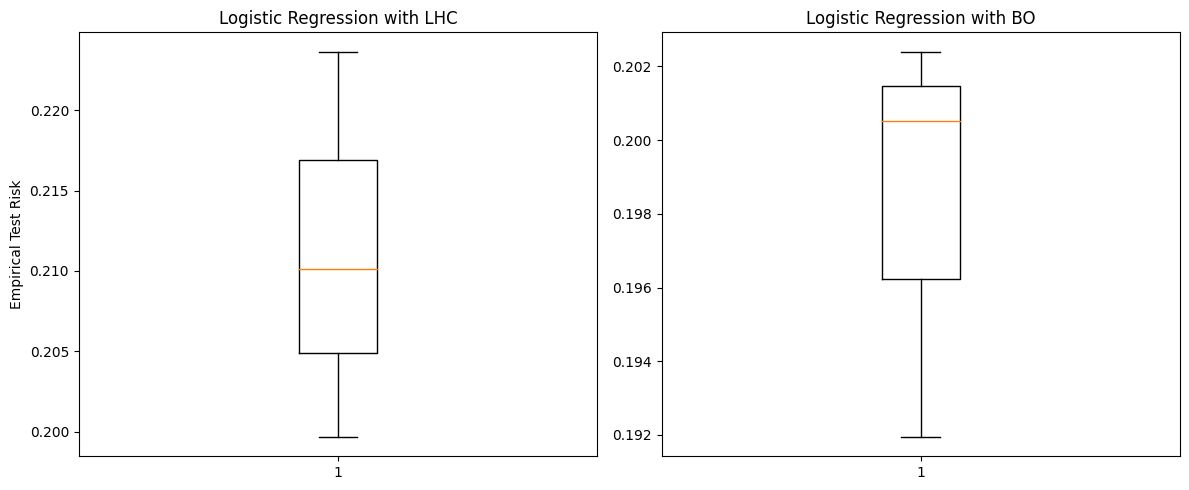

In [8]:
print("mean of empirical test risks via LHC (resampled test risk):", resampled_test_risk_LHC,
      "\nmedian of empirical test risks via LHC:", np.median(outer_scores_LHC), 
      "\nstandard deviation of empirical test risks via LHC:", np.std(outer_scores_LHC, ddof=1),
      "\n\nmean of empirical test risks via BO (resampled test risk):", resampled_test_risk_BO, 
      "\nmedian of empirical test risks via BO:", np.median(outer_scores_BO),
      "\nstandard deviation of empirical test risks via BO:", np.std(outer_scores_BO, ddof=1))

# Boxplot visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].boxplot(outer_scores_LHC)
axs[0].set_title('Logistic Regression with LHC')
axs[0].set_ylabel('Empirical Test Risk')
axs[1].boxplot(outer_scores_BO)
axs[1].set_title('Logistic Regression with BO')
plt.tight_layout()
plt.show()
end_time = time.time()

### 6. Report Results


We evaluated two hyperparameter tuning strategies for a logistic regression classifier on the Fashion dataset (3,500 samples, 28×28 features, 10 classes): **Latin Hypercube Sampling (LHC)** and **Bayesian Optimization (BO)**.

---
#### Methodology 
- **Nested K-Fold Cross Validation:** (Outer folds: 5; Inner folds: 2)
- **Hyperparameters tuned:**  
  - PCA variance retained (`n_components`)  
  - Regularization strength (`λ = 1/C`)  
- **Hyperparameter Search:** 10 sampels per outer fold

#### Results  

| Metric | LHC | BO |
|--------|-----|----|
| Mean emp. test risk (resampled) | 0.2111 | **0.1983** |
| Median emp. test risk | 0.2101 | **0.2005** |
| Standard deviation emp. test risk | 0.0120 | **0.0056** |
| Accuracy | 78.89% | **80.17%** |
| Runtime | **47.24 s** | 88.70 s |

**NOTE:** The experiments were conducted using an AMD RYZEN 5 5500U (16 GB RAM). Therefore, only restrictive computational capacity were given with regards to e.g. sample size of parameters or the domain of the hyperparameters for Bayes Optimization. 

---
#### Analysis
The results show that logistic regression with hyperparameters via Bayesian Optimization (BO) achieved slightly better average performance compared to Latin Hypercube Sampling (LHC), with a resampled test risk of **0.1983** versus **0.2111** for LHC. This corresponds to an accuracy of approximately **80.2%** for BO and **78.9%** for LHC. Beyond the mean performance, BO demonstrated much lower variance regarding the empirical test risks (std: **0.0056**) compared to LHC (std: **0.0120**), indicating that BO provides more stable and reliable predictions regardless of the specific resample. The variance resulting from hyperparameters via LHC is twice as high compared to BO, which indicates higher sensitivity to specific outer folds.

However, the computational cost for BO is almost double that of LHC (**88.70 s vs. 47.24 s**). This means that while BO offers slightly better accuracy and consistency, it comes at the expense of higher runtime.  

#### Conclusion & Recommendation
In summary, weighing **effectiveness** (resampled test risk/accuracy) and **efficiency** (computation time/runtime) for this dataset and model setup with regard to the given hardware and capacity, the logistic regression model with hyperparameters via LHC is better suited. The performance is almost equal to the model with hyperparameters via BO, but the overall experiment requires half as much runtime. 
